<a href="https://colab.research.google.com/github/Mohamed209/Deep_Learning_Notes/blob/master/DCGAN/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# download data
!wget --header="Host: doc-10-7o-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,ar-EG;q=0.8,ar;q=0.7" --header="Referer: https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg" --header="Cookie: AUTH_u2j0t6bv6dftjmt2lsba7r3rvpi7gdis_nonce=hvpa42lp27im8" --header="Connection: keep-alive" "https://doc-10-7o-docs.googleusercontent.com/docs/securesc/3dqr5f7kd72k46kubklelqd888nobt2a/olk7s8bt27ureep3b4b8hq2fdrfko630/1590264675000/13182073909007362810/01449274755406512808/0B7EVK8r0v71pZjFTYXZWM3FlRnM?e=download&authuser=0&nonce=hvpa42lp27im8&user=01449274755406512808&hash=ee2ej8c1n70t4p13t2ai3r45cuiuh2l5" -c -O 'img_align_celeba.zip'

--2020-05-23 20:12:58--  https://doc-10-7o-docs.googleusercontent.com/docs/securesc/3dqr5f7kd72k46kubklelqd888nobt2a/olk7s8bt27ureep3b4b8hq2fdrfko630/1590264675000/13182073909007362810/01449274755406512808/0B7EVK8r0v71pZjFTYXZWM3FlRnM?e=download&authuser=0&nonce=hvpa42lp27im8&user=01449274755406512808&hash=ee2ej8c1n70t4p13t2ai3r45cuiuh2l5
Resolving doc-10-7o-docs.googleusercontent.com (doc-10-7o-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to doc-10-7o-docs.googleusercontent.com (doc-10-7o-docs.googleusercontent.com)|108.177.119.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘img_align_celeba.zip’

img_align_celeba.zi     [       <=>          ]   1.34G  56.5MB/s    in 28s     

2020-05-23 20:13:27 (50.0 MB/s) - ‘img_align_celeba.zip’ saved [1443490838]



In [8]:
# extract dataset
!mkdir celeba
!unzip img_align_celeba.zip -d celeba/

Streaming output truncated to the last 5000 lines.
 extracting: celeba/img_align_celeba/197601.jpg  
 extracting: celeba/img_align_celeba/197602.jpg  
 extracting: celeba/img_align_celeba/197603.jpg  
 extracting: celeba/img_align_celeba/197604.jpg  
 extracting: celeba/img_align_celeba/197605.jpg  
 extracting: celeba/img_align_celeba/197606.jpg  
 extracting: celeba/img_align_celeba/197607.jpg  
 extracting: celeba/img_align_celeba/197608.jpg  
 extracting: celeba/img_align_celeba/197609.jpg  
 extracting: celeba/img_align_celeba/197610.jpg  
 extracting: celeba/img_align_celeba/197611.jpg  
 extracting: celeba/img_align_celeba/197612.jpg  
 extracting: celeba/img_align_celeba/197613.jpg  
 extracting: celeba/img_align_celeba/197614.jpg  
 extracting: celeba/img_align_celeba/197615.jpg  
 extracting: celeba/img_align_celeba/197616.jpg  
 extracting: celeba/img_align_celeba/197617.jpg  
 extracting: celeba/img_align_celeba/197618.jpg  
 extracting: celeba/img_align_celeba/197619.jpg  

In [9]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [0]:
# Root directory for dataset
dataroot = "celeba/"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [0]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [0]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

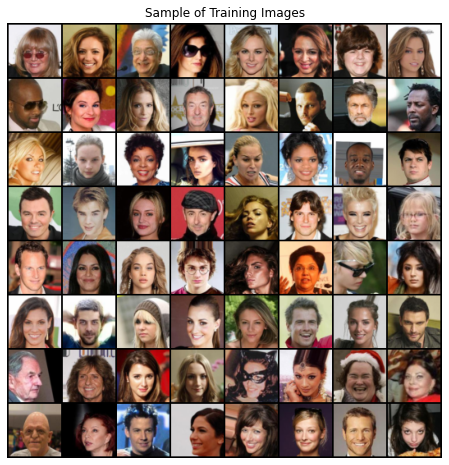

In [13]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Sample of Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02) # All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# discriminator network
# CNN acts as binary classifier
# input >>> (3,64,64) image
# output >>> For the discriminator, single sigmoid output

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.__network = nn.Sequential(
            # input tensor to discriminator network is (3,64,64)
            nn.Conv2d(in_channels=nc, out_channels=ndf,
                      kernel_size=4, stride=2, padding=1, bias=False),
            # output of first conv layer >>>> tesnsor (ndf,32,32)
            # this (ndf,32,32) tensor will be element wise undergo nonlinear activation with leakyrelu
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # output after activation >>>> tensor (ndf,32,32) element wise leakyrelued
            nn.Conv2d(in_channels=ndf, out_channels=ndf*2,
                      kernel_size=4, stride=2, padding=1, bias=False),
            # out after second conv >>>> tensor (ndf*2,16,16)
            nn.BatchNorm2d(num_features=ndf*2),
            # out after batchnorm >>>> tensor (ndf*2,16,16)
            nn.LeakyReLU(0.2, inplace=True),
            # output after activation >>>> tensor (ndf*2,16,16) element wise leakyrelued
            nn.Conv2d(in_channels=ndf*2, out_channels=ndf*4,
                      kernel_size=4, stride=2, padding=1, bias=False),
            # out after third conv >>>> tensor (ndf*4,8,8)
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8,
                      kernel_size=4, stride=2, padding=1, bias=False),
            # out after 4th conv layer >>> tensor (ndf*8,4,4)
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=ndf * 8, out_channels=1,
                      kernel_size=4, stride=1, padding=0, bias=False),
            # out after 5th conv layer >>>> tensor (1,1,1)
            nn.Sigmoid()  # out >>>> value between [0,1]
        )

    def forward(self, input_tensor):
        """
        - override forward function in Module class to implement sequential forward data propagation
        - apply forward pass on (3,64,64) tensor and return probability of tensor being real
        """
        return self.__network.forward(input_tensor)


In [16]:
# create Discriminator network
netD = Discriminator().to(device) # send model to GPU
netD.apply(weights_init)
print(netD)

Discriminator(
  (_Discriminator__network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [0]:
# before start implementing generator , first we need to imagine how transposed convolution works
# check this useful link >>>> http://d2l.ai/chapter_computer-vision/transposed-conv.html?highlight=transposed

In [0]:
# Generator network
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.__network=nn.Sequential(
            # generator receives tensor with 100 elements (z)
            nn.ConvTranspose2d(in_channels=nz,out_channels=ngf*8,kernel_size=4,bias=False),
            # out now is >>>> (nfg*8,4,4)
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            # out now (nfg*8,4,4) batch normed and activated with Relu
            nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # out now (ngf*4) x 8 x 8 batch normed and activated with Relu
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # out now (ngf*2) x 16 x 16 batch normed and activated with Relu
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # out now ngf x 32 x 32 batch normed and activated with Relu
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # out now. (nc) x 64 x 64 Tanh activated between [-1,1]
        )
        
    def forward(self, input_tensor):
      """
      - override forward function in Module class to implement sequential forward data propagation
      - apply forward generation pass on (100) tensor (z) and return generated tensor (nc,64,64)
      """
      return self.__network.forward(input_tensor)

In [19]:
# create Generator network
netG = Generator().to(device) # send model to GPU
netG.apply(weights_init)
print(netG)

Generator(
  (_Generator__network): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13)

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(size=(64, nz, 1, 1), device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [0]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad() # remove/reset network gradients from last iterations
        # Format batch
        real_batch = data[0].to(device)
        b_size = real_batch.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD.forward(real_batch).view(-1) # flatten output tensor
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG.forward(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD.forward(fake.detach()).view(-1) # detach teansor as it does not require grad
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D weights
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD.forward(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/10][0/1583]	Loss_D: 1.8827	Loss_G: 5.4581	D(x): 0.6336	D(G(z)): 0.6768 / 0.0070
[0/10][50/1583]	Loss_D: 0.2774	Loss_G: 20.6053	D(x): 0.9147	D(G(z)): 0.0000 / 0.0000
[0/10][100/1583]	Loss_D: 0.6996	Loss_G: 10.1000	D(x): 0.9683	D(G(z)): 0.3646 / 0.0008
[0/10][150/1583]	Loss_D: 0.8143	Loss_G: 7.1744	D(x): 0.8893	D(G(z)): 0.4244 / 0.0048
[0/10][200/1583]	Loss_D: 0.2292	Loss_G: 3.2399	D(x): 0.9638	D(G(z)): 0.1508 / 0.0758
[0/10][250/1583]	Loss_D: 0.3676	Loss_G: 4.2027	D(x): 0.9361	D(G(z)): 0.2212 / 0.0311
[0/10][300/1583]	Loss_D: 1.3182	Loss_G: 6.7371	D(x): 0.9456	D(G(z)): 0.6559 / 0.0057
[0/10][350/1583]	Loss_D: 0.6755	Loss_G: 2.8090	D(x): 0.6774	D(G(z)): 0.1210 / 0.1016
[0/10][400/1583]	Loss_D: 1.7304	Loss_G: 5.1725	D(x): 0.3142	D(G(z)): 0.0015 / 0.0266
[0/10][450/1583]	Loss_D: 0.4436	Loss_G: 4.0170	D(x): 0.8783	D(G(z)): 0.1831 / 0.0404
[0/10][500/1583]	Loss_D: 0.3988	Loss_G: 4.3233	D(x): 0.8676	D(G(z)): 0.1759 / 0.0256
[0/10][550/1583]	Loss_D: 0.6883	Loss_G: 3.3636	D(x): 0.6737	D(G(z)

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
!mkdir generator_weights/

In [0]:
# save generator best weights
torch.save(netG.state_dict(), 'generator_weights/')